# **MÔ HÌNH DỰ ĐOÁN GIÁ XE BẰNG LINEAR REGRESSION**

#Nhóm 9:
23122018 Lại Nguyễn Hồng Thanh\
23122019 Phan Huỳnh Châu Thịnh\
23122029 Nguyễn Trọng Hòa\
23122047 Nguyễn Xuân Quang

## *Import các thư viện cần thiết*

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns #Dùng để vẽ biểu đồ và kiểm tra tương quan
import math

## *Tải xuống file*
Tải xuống file "trains.csv" từ link: [trains.csv](https://docs.google.com/spreadsheets/d/12sp2j52V-PMawKejVT7aIBnzSABBXVfXyO75EVCbuTU/gviz/tq?tqx=out:csv)

In [131]:
def download_google_sheets(csv_url, file_path="trains.csv"):
    try:
        df = pd.read_csv(csv_url)
        df.to_csv(file_path, index=False)
        print(f"File đã tải xuống và lưu tại: {file_path}")
        return df
    except Exception as e:
        print(f"Lỗi khi tải file: {e}")
        return None

In [132]:
csv_url = "https://docs.google.com/spreadsheets/d/12sp2j52V-PMawKejVT7aIBnzSABBXVfXyO75EVCbuTU/gviz/tq?tqx=out:csv"
df = download_google_sheets(csv_url, "train.csv")


File đã tải xuống và lưu tại: train.csv


## *Đọc dữ liệu*

In [133]:
#Thông tin về tập dữ liệu
print(f"Số dòng, số cột: {df.shape}")
print("Tên các cột: ", df.columns.tolist())

#Hiển thị 5 dòng đầu tiên của tập dữ liệu huấn luyện
df.head()

Số dòng, số cột: (1647, 20)
Tên các cột:  ['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,Individual,1995 cc,184 bhp @ 4000 rpm,350 Nm @ 1750 rpm,RWD,4454.0,2044.0,1545.0,5.0,63.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,Individual,1997 cc,138 bhp @ 3750 rpm,320 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,Individual,2925 cc,326 bhp @ 3600 rpm,700 Nm @ 1200 rpm,AWD,5207.0,2157.0,1823.0,7.0,90.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,Individual,2755 cc,174 bhp @ 3400 rpm,450 Nm @ 1600 rpm,RWD,4795.0,1855.0,1835.0,7.0,80.0


# *Tiền xử lý dữ liệu*

## Xử lý đơn vị dữ liệu
1. Xử lý cột Engine
    -> Bỏ đơn vị "cc" để đưa Engine về dạng số float
2. Xử lý cột Max Power
    -> Tách thành 2 cột Max Power (bhp) và Power RPM (rpm)
3. Xử lý cột Max Torque
    -> Tách thành 2 cột Max Torque (Nm) và Torque RPM (rpm)

In [134]:
def process_units(df):
    """Xử lý các đơn vị đo lường như Engine, Max Power, Max Torque."""
    df["Engine"] = df["Engine"].str.replace(" cc", "", regex=True).astype(float)
    df[["Max Power", "Power RPM"]] = df["Max Power"].str.extract(r"(\d+\.?\d*)\s*bhp\s*@?\s*(\d*)")
    df["Max Power"] = df["Max Power"].astype(float)
    df["Power RPM"] = df["Power RPM"].replace("", np.nan).astype(float)
    df[["Max Torque", "Torque RPM"]] = df["Max Torque"].str.extract(r"(\d+\.?\d*)\s*Nm\s*(?:@|at)?\s*(\d+)?")
    df["Max Torque"] = df["Max Torque"].astype(float)
    df["Torque RPM"] = df["Torque RPM"].astype(float)
    return df
df = process_units(df)

In [135]:
#Dữ liệu sau khi xử lý đơn vị
#In ra 5 dòng dữ liệu
df[["Engine", "Max Power", "Power RPM", "Max Torque", "Torque RPM"]].head(5)

,Engine,Max Power,Power RPM,Max Torque,Torque RPM
0,NaN,NaN,NaN,NaN,NaN
1,1995.0,184.0,4000.0,350.0,1750.0
2,1997.0,138.0,3750.0,320.0,1600.0
3,2925.0,326.0,3600.0,700.0,1200.0
4,2755.0,174.0,3400.0,450.0,1600.0


## Xử lý dữ liệu bị thiếu

### *Kiểm tra dữ liệu bị thiếu*

In [136]:
#Kiểm tra dữ liệu bị thiếu
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Số lượng dữ liệu bị thiếu: ")
print(missing_values)

Số lượng dữ liệu bị thiếu: 
Engine                 65
Max Power             168
Max Torque            168
Drivetrain            111
Length                 52
Width                  52
Height                 52
Seating Capacity       52
Fuel Tank Capacity     90
Power RPM             172
Torque RPM            168
dtype: int64


### *Xử lý dữ liệu bị thiếu*
Xử lý bằng cách điền giá trị cho các cột bị thiếu dựa trên loại dữ liệu của chúng.
1. Cột số ("Length", "Width", "Height", "Seating Capacity", "Fuel Tank Capacity", "Engine", "Max Power", "Max Torque")
    -> Điền bằng **(median)** vì có thể có outlier.
2. Cột phân loại ("Drivetrain")
    -> Điền bằng **mode**
3. Cột có số lượng thiếu quá lớn (>50% dữ liệu)
    -> Xem xét việc xóa cột

In [137]:
def handle_missing_values(df):
    """Xử lý giá trị thiếu cho cả dữ liệu số và phân loại."""
    num_cols = ["Engine", "Max Power", "Power RPM", "Max Torque", "Torque RPM", "Length", "Width", "Height", "Seating Capacity", "Fuel Tank Capacity"]
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)

    cat_cols = ["Drivetrain"]
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

df = handle_missing_values(df)

<ipython-input-137-e86bc27d251b>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-137-e86bc27d251b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [138]:
#Kiểm tra lại sau khi xử lý
missing_values = df.isnull().sum()

print("Số lượng dữ liệu bị thiếu: ")
print(missing_values)

Số lượng dữ liệu bị thiếu: 
Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
Power RPM             0
Torque RPM            0
dtype: int64


## Mã hóa dữ liệu

### *Kiểm tra các cột cần mã hóa*

In [139]:
categorical_cols = df.select_dtypes(exclude = ["number"]).columns.tolist()
print("Các cột cần mã hóa: ", categorical_cols)
df.head()

Các cột cần mã hóa:  ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Power RPM,Torque RPM
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,...,117.0,204.0,FWD,4370.0,1775.0,1550.0,5.0,50.0,4200.0,1800.0
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,...,184.0,350.0,RWD,4454.0,2044.0,1545.0,5.0,63.0,4000.0,1750.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,...,138.0,320.0,FWD,4585.0,1890.0,1785.0,7.0,70.0,3750.0,1600.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,...,326.0,700.0,AWD,5207.0,2157.0,1823.0,7.0,90.0,3600.0,1200.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,...,174.0,450.0,RWD,4795.0,1855.0,1835.0,7.0,80.0,3400.0,1600.0


### *Mã hóa*
1. One-Hot Encoding + Frequency
  - Make
  - Model
  - Location
2. One-Hot Encoding
  - Fuel Type: Chuyển thành 3 nhóm Diesel, Petrol và Others (gồm các loại nguyên liệu ít xuất hiện)
  - Transmission
  - Color: Giữa 6 màu phổ biến nhất và gom các màu còn lại thành
  Others.
  - Drivetrain
3. Label Encoding
  - Owner
4. **Xóa cột Seller Type**: vì có quá nhiều phần tử 'Individual' -> Độ tương quan với Price hiển nhiên sẽ kém. Ta xóa trước mà không cần tính toán.
  

In [140]:
#Seller Type
print(df['Seller Type'].value_counts())

Seller Type
Individual                 1595
Corporate                    47
Commercial Registration       5
Name: count, dtype: int64


In [141]:
df['Color'].value_counts()

,count
Color,
White,647
Silver,222
Grey,176
Blue,144
Black,135
Red,120
Brown,70
Maroon,33
Gold,25


In [142]:
def encode_categorical(df):
    """Mã hóa các biến phân loại như Fuel Type, Transmission, Color, Drivetrain, Owner."""
    df['Fuel Type'] = df['Fuel Type'].apply(lambda x: x if x in ['Diesel', 'Petrol'] else 'Others')
    df = pd.get_dummies(df, columns=['Fuel Type'], prefix='Fuel', dtype=int)
    df = pd.get_dummies(df, columns=['Transmission'], prefix='Transmission', dtype=int)

    top_colors = df['Color'].value_counts().nlargest(6).index.tolist()
    df['Color'] = df['Color'].apply(lambda x: x if x in top_colors else 'Others')
    df = pd.get_dummies(df, columns=['Color'], prefix='Color', dtype=int)

    df = pd.get_dummies(df, columns=['Drivetrain'], prefix='Drivetrain', dtype=int)

    df['is_registered'] = (df['Owner'] != 'UnRegistered Car').astype(int)
    owner_mapping = {"UnRegistered Car": 0, "First": 1, "Second": 2, "Third": 3}
    df['Owner'] = df['Owner'].map(owner_mapping)

    return df

In [143]:
def process_price_related_features(df):
    # Tạo bản sao để tránh cảnh báo SettingWithCopyWarning
    df_processed = df.copy()

    # Make
    make_counts = df_processed['Make'].value_counts()
    cumulative_pct = make_counts.cumsum() / make_counts.sum() * 100
    n_makes_for_80_pct = (cumulative_pct <= 80).sum() + 1
    top_makes = make_counts.nlargest(10).index.tolist()

    for make in top_makes:
        df_processed.loc[:, f'Make_{make}'] = (df_processed['Make'] == make).astype(int)

    df_processed.loc[:, 'Make_Other'] = (~df_processed['Make'].isin(top_makes)).astype(int)

    # Model
    model_counts = df_processed['Model'].value_counts()
    top_models = model_counts.nlargest(15).index.tolist()

    for model in top_models:
        df_processed.loc[:, f'Model_{model}'] = (df_processed['Model'] == model).astype(int)

    df_processed.loc[:, 'Model_Other'] = (~df_processed['Model'].isin(top_models)).astype(int)

    # Location
    location_freq = df_processed['Location'].value_counts(normalize=True)
    df_processed.loc[:, 'Location_Freq'] = df_processed['Location'].map(location_freq).fillna(0)

    location_counts = df_processed['Location'].value_counts()
    top_locations = location_counts.nlargest(10).index.tolist()

    for location in top_locations:
        df_processed.loc[:, f'Location_{location}'] = (df_processed['Location'] == location).astype(int)

    df_processed.loc[:, 'Location_Other'] = (~df_processed['Location'].isin(top_locations)).astype(int)

    # Xóa các cột gốc sau khi đã mã hóa
    df_processed = df_processed.drop(columns=['Make', 'Model', 'Location'])

    # Seller Type
    df_processed = df_processed.drop(columns=['Seller Type'], errors='ignore')

    return df_processed
df_c = process_price_related_features(df)
df_c = encode_categorical(df_c)

In [144]:
df_c

,Price,Year,Kilometer,Owner,Engine,Max Power,Max Torque,Length,Width,Height,...,Color_Blue,Color_Grey,Color_Others,Color_Red,Color_Silver,Color_White,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD,is_registered
0,800000,2012,75576,2.0,1498.0,117.0,204.0,4370.0,1775.0,1550.0,...,0,0,0,0,0,1,0,1,0,1
1,2199000,2016,77000,1.0,1995.0,184.0,350.0,4454.0,2044.0,1545.0,...,0,0,0,0,0,0,0,0,1,1
2,800000,2017,112000,1.0,1997.0,138.0,320.0,4585.0,1890.0,1785.0,...,0,0,0,0,1,0,0,1,0,1
3,12900000,2021,3000,1.0,2925.0,326.0,700.0,5207.0,2157.0,1823.0,...,0,0,0,0,0,1,1,0,0,1
4,3499000,2019,73000,1.0,2755.0,174.0,450.0,4795.0,1855.0,1835.0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,635000,2016,92000,2.0,1248.0,89.0,200.0,4490.0,1730.0,1485.0,...,0,0,0,0,0,1,0,1,0,1
1643,777000,2014,9212,1.0,1498.0,117.0,204.0,4370.0,1775.0,1550.0,...,0,1,0,0,0,0,0,1,0,1
1644,369000,2017,16800,1.0,998.0,67.0,90.0,3545.0,1490.0,1475.0,...,0,1,0,0,0,0,0,1,0,1
1645,2280000,2014,68000,1.0,1995.0,217.0,450.0,4899.0,2094.0,1464.0,...,1,0,0,0,0,0,0,0,1,1


## Chọn các cột dữ liệu trong X

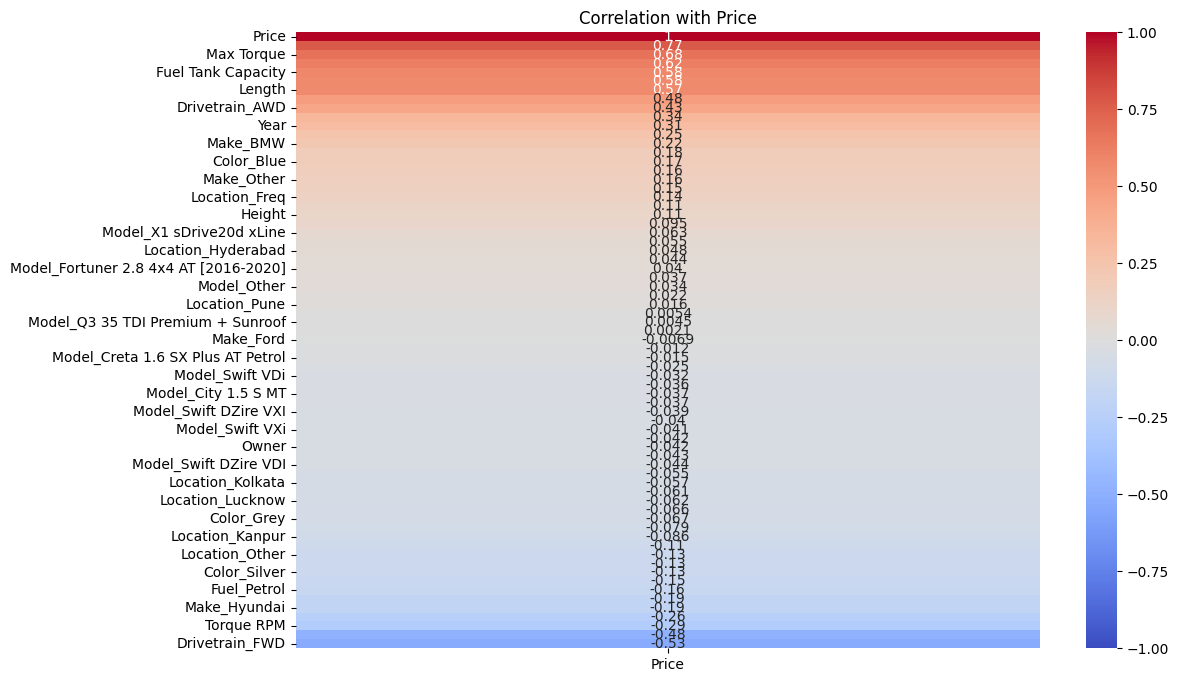

In [145]:
corr_matrix = df_c.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Price']].sort_values(by='Price', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Price')
plt.show()


In [146]:
def select_high_corr_features(df, threshold=0.31):

    if 'Price' not in df.columns:
        raise ValueError("Không thể chọn cột vì tập dữ liệu không có 'Price'.")

    corr_matrix = df.corr()

    low_corr_columns = corr_matrix['Price'][abs(corr_matrix['Price']) < threshold].index.tolist()

    df_selected = df.drop(columns=low_corr_columns)

    return df_selected
df_c = select_high_corr_features(df_c)
selected_columns = df_c.columns.tolist()
df_c.head()

,Price,Year,Engine,Max Power,Max Torque,Length,Width,Fuel Tank Capacity,Make_Mercedes-Benz,Transmission_Automatic,Transmission_Manual,Drivetrain_AWD,Drivetrain_FWD
0,800000,2012,1498.0,117.0,204.0,4370.0,1775.0,50.0,0,1,0,0,1
1,2199000,2016,1995.0,184.0,350.0,4454.0,2044.0,63.0,0,1,0,0,0
2,800000,2017,1997.0,138.0,320.0,4585.0,1890.0,70.0,0,0,1,0,1
3,12900000,2021,2925.0,326.0,700.0,5207.0,2157.0,90.0,1,1,0,1,0
4,3499000,2019,2755.0,174.0,450.0,4795.0,1855.0,80.0,0,1,0,0,0


Tiến hành xóa những cột có độ tương quan yếu so với Price (trí tuyệt đối bé hơn 0.31).

Những cột được chọn: ['Year',
 'Engine',
 'Max Power',
 'Max Torque',
 'Length',
 'Width',
 'Fuel Tank Capacity',
 'Make_Mercedes-Benz',
 'Transmission_Automatic',
 'Transmission_Manual',
 'Drivetrain_AWD',
 'Drivetrain_FWD']

In [147]:
numerical_cols = []
for col in df_c.columns:
  if (col != "Price" and col != "Price_Log"):
    numerical_cols.append(col)
numerical_cols

['Year',
 'Engine',
 'Max Power',
 'Max Torque',
 'Length',
 'Width',
 'Fuel Tank Capacity',
 'Make_Mercedes-Benz',
 'Transmission_Automatic',
 'Transmission_Manual',
 'Drivetrain_AWD',
 'Drivetrain_FWD']

In [148]:
X = df_c[numerical_cols].values
Y = df_c["Price"].values.reshape(-1, 1)

In [149]:
Y

array([[ 800000],
       [2199000],
       [ 800000],
       ...,
       [ 369000],
       [2280000],
       [ 422000]])

In [150]:
X

array([[2.012e+03, 1.498e+03, 1.170e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.016e+03, 1.995e+03, 1.840e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.017e+03, 1.997e+03, 1.380e+02, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [2.017e+03, 9.980e+02, 6.700e+01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [2.014e+03, 1.995e+03, 2.170e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.018e+03, 1.196e+03, 7.300e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

## *Chia tập dữ liệu*


###Cross Validation

In [151]:
def k_fold_split(X, Y, K=10):
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    fold_size = n_samples // K

    folds = []
    for i in range(K):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)

        X_train, Y_train = X[train_indices], Y[train_indices]
        X_val, Y_val = X[val_indices], Y[val_indices]

        folds.append((X_train, Y_train, X_val, Y_val))

    print(f"Đã chia thành {K} folds cho cross-validation!")
    return folds

In [152]:
folds = k_fold_split(X, Y, K=10)

Đã chia thành 10 folds cho cross-validation!


# *Linear Regression*

## Kiểm tra tương quan giữa các biến

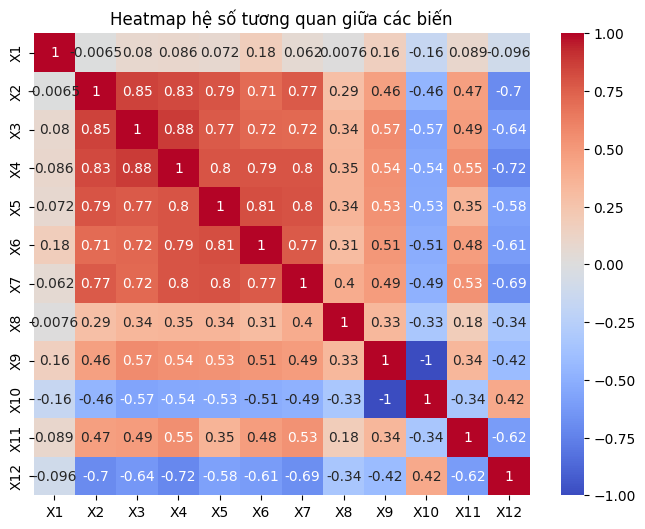

In [153]:
corr_matrix = np.corrcoef(X.T)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels=[f'X{i+1}' for i in range(X.shape[1])],
            yticklabels=[f'X{i+1}' for i in range(X.shape[1])])
plt.title("Heatmap hệ số tương quan giữa các biến")
plt.show()

##Chọn công thức

In [154]:
def calculate_correlations(X, Y):
    transformations = {
        'Tuyến tính': lambda x: x,
        'Bình phương': lambda x: x**2,
        'Căn bậc hai': lambda x: np.sqrt(np.abs(x)),
        'Logarit': lambda x: np.log1p(np.abs(x)),
        'Nghịch đảo': lambda x: 1 / (np.abs(x) + 1),
        'Bậc 3': lambda x: x**3
    }

    correlation_results = []

    for i in range(X.shape[1]):
        var_results = {'Biến': f'X{i+1}'}

        for name, transform in transformations.items():
            X_transformed = transform(X[:, i])

            corr = np.corrcoef(X_transformed, Y.ravel())[0, 1]
            var_results[name] = abs(corr)

        correlation_results.append(var_results)

    df_correlations = pd.DataFrame(correlation_results)

    return df_correlations

def analyze_variables(X_train, Y_train):
    correlation_table = calculate_correlations(X_train, Y_train)

    print("Bảng tương quan các biến với các phép biến đổi:")
    print(correlation_table.to_string(index=False, float_format='{:.4f}'.format))

    num_vars = X_train.shape[1]
    rows = math.ceil(num_vars / 3)

    plt.figure(figsize=(15, 5 * rows))

    for i in range(num_vars):
        plt.subplot(rows, 3, i+1)
        plt.scatter(X_train[:, i], Y_train)
        plt.title(f'Scatter Plot: X{i+1} vs Y')
        plt.xlabel(f'X{i+1}')
        plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    transformations = {
        'Bình phương': lambda x: x**2,
        'Căn bậc hai': lambda x: np.sqrt(np.abs(x)),
        'Logarit': lambda x: np.log1p(np.abs(x))
    }

    for i in range(X_train.shape[1]):
        plt.figure(figsize=(15, 5))

        for j, (name, transform) in enumerate(transformations.items(), 1):
            plt.subplot(1, 3, j)
            plt.scatter(transform(X_train[:, i]), Y_train)
            plt.title(f'X{i+1} - {name}')
            plt.xlabel(f'{name}(X{i+1})')
            plt.ylabel('Y')

        plt.tight_layout()
        plt.show()

    return correlation_table

Bảng tương quan các biến với các phép biến đổi:
Biến  Tuyến tính  Bình phương  Căn bậc hai  Logarit  Nghịch đảo  Bậc 3
  X1      0.3111       0.3113       0.3110   0.3109      0.3106 0.3115
  X2      0.6228       0.6200       0.6044   0.5791      0.5181 0.5546
  X3      0.7687       0.7583       0.7326   0.6810      0.5602 0.6598
  X4      0.6787       0.7143       0.6406   0.5915      0.4776 0.7059
  X5      0.5737       0.5931       0.5637   0.5535      0.5328 0.6114
  X6      0.5768       0.5885       0.5699   0.5624      0.5458 0.5973
  X7      0.5824       0.5985       0.5687   0.5519      0.5064 0.6003
  X8      0.3436       0.3436       0.3436   0.3436      0.3436 0.3436
  X9      0.4812       0.4812       0.4812   0.4812      0.4812 0.4812
 X10      0.4812       0.4812       0.4812   0.4812      0.4812 0.4812
 X11      0.4305       0.4305       0.4305   0.4305      0.4305 0.4305
 X12      0.5255       0.5255       0.5255   0.5255      0.5255 0.5255


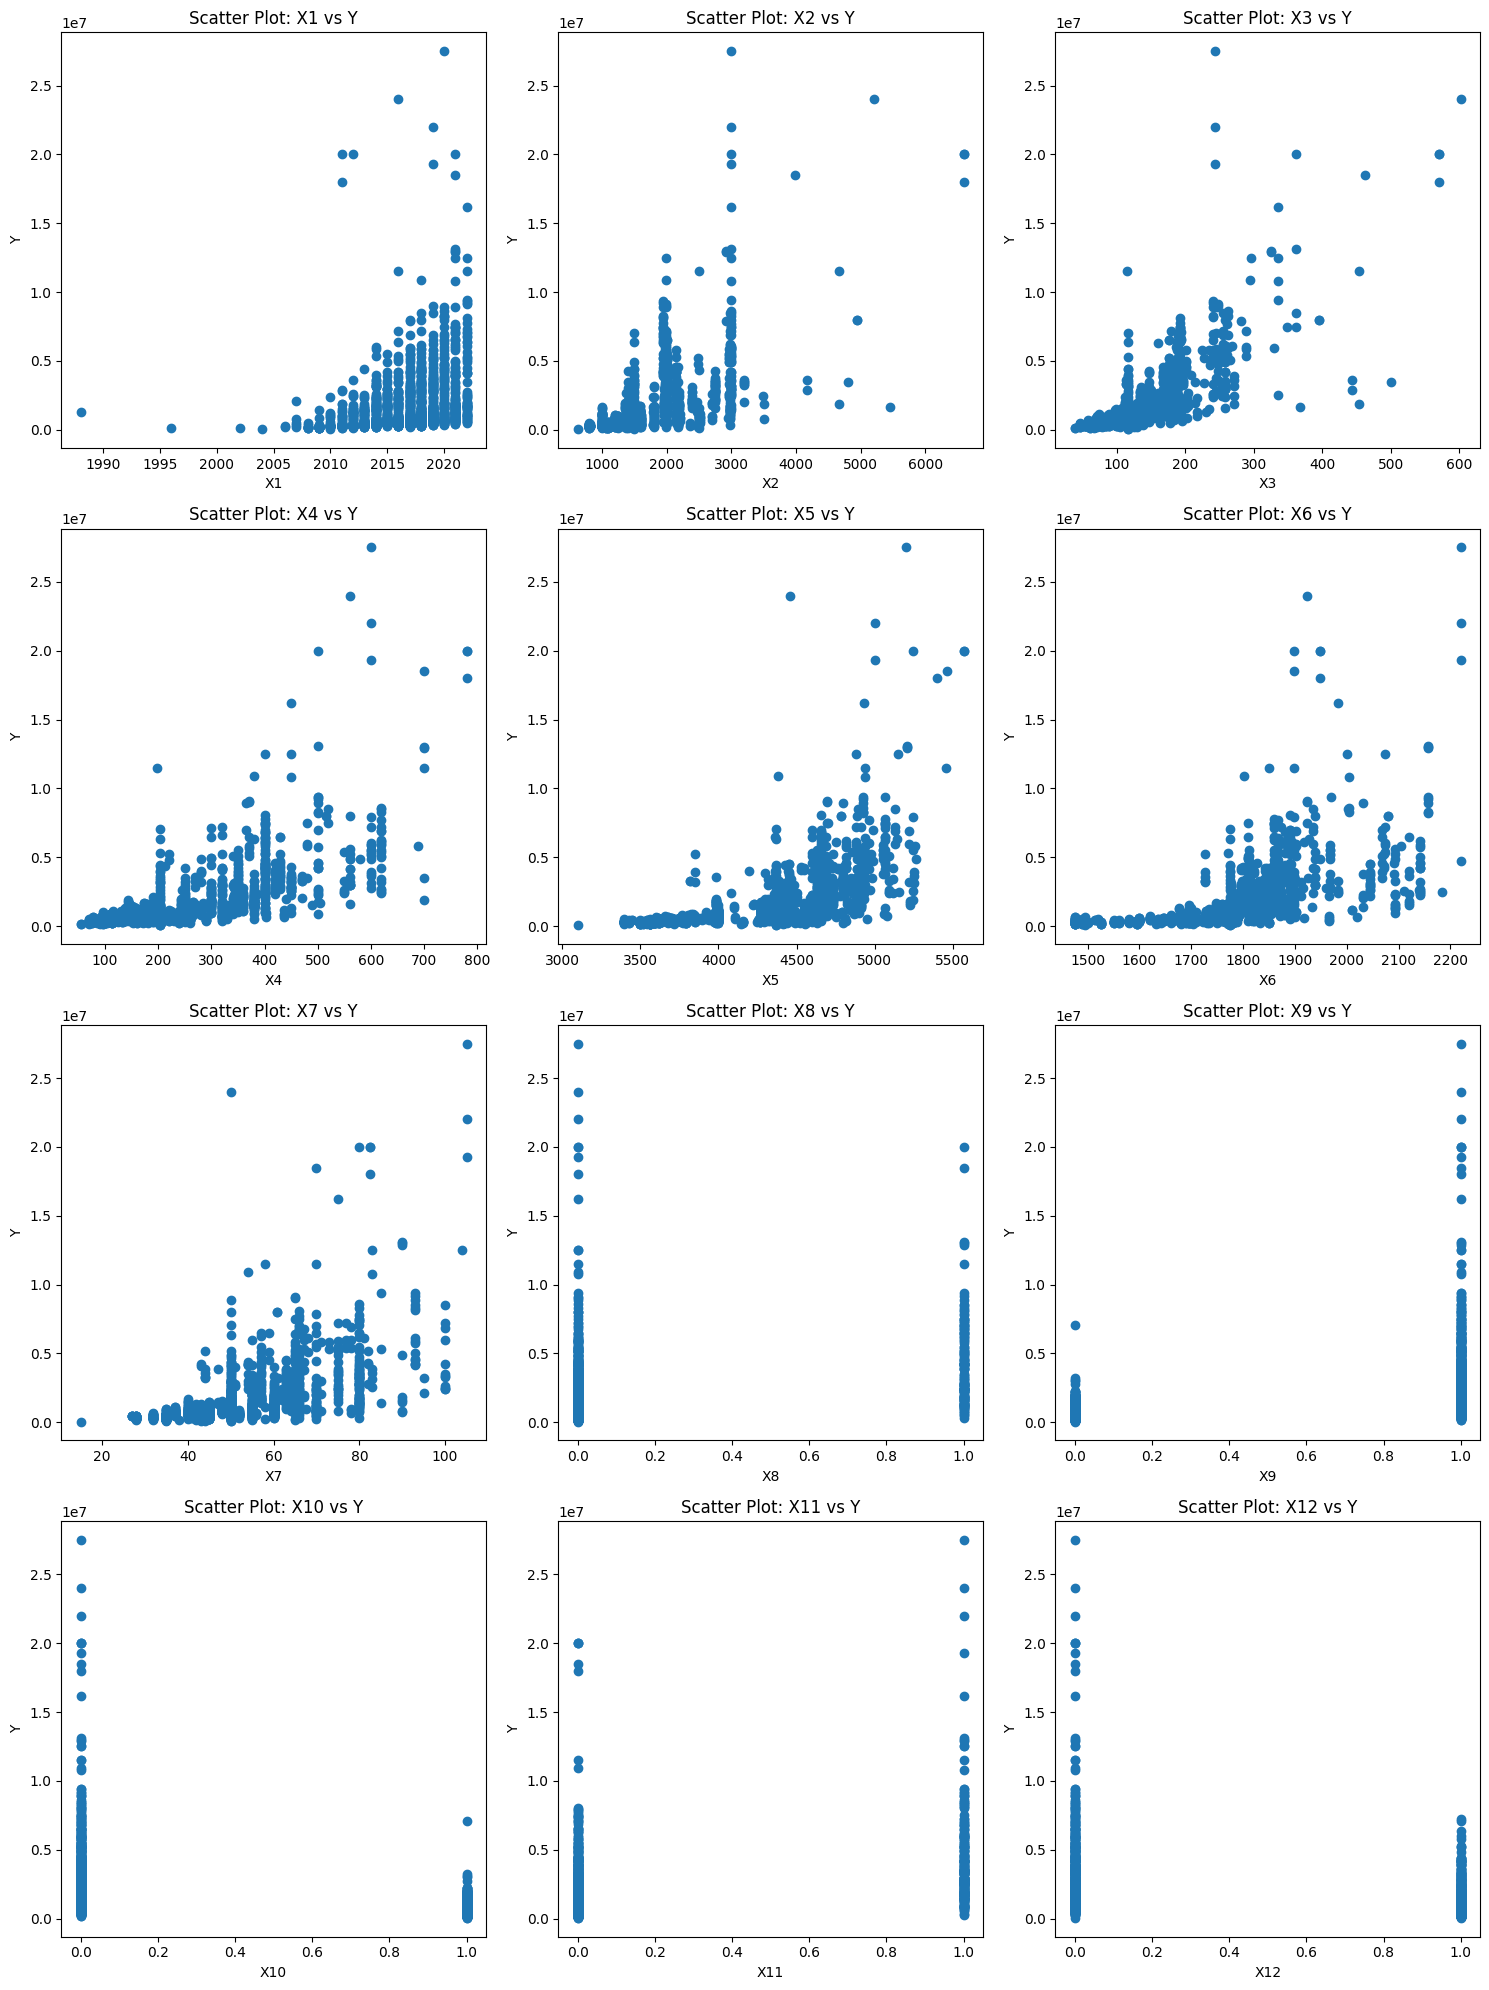

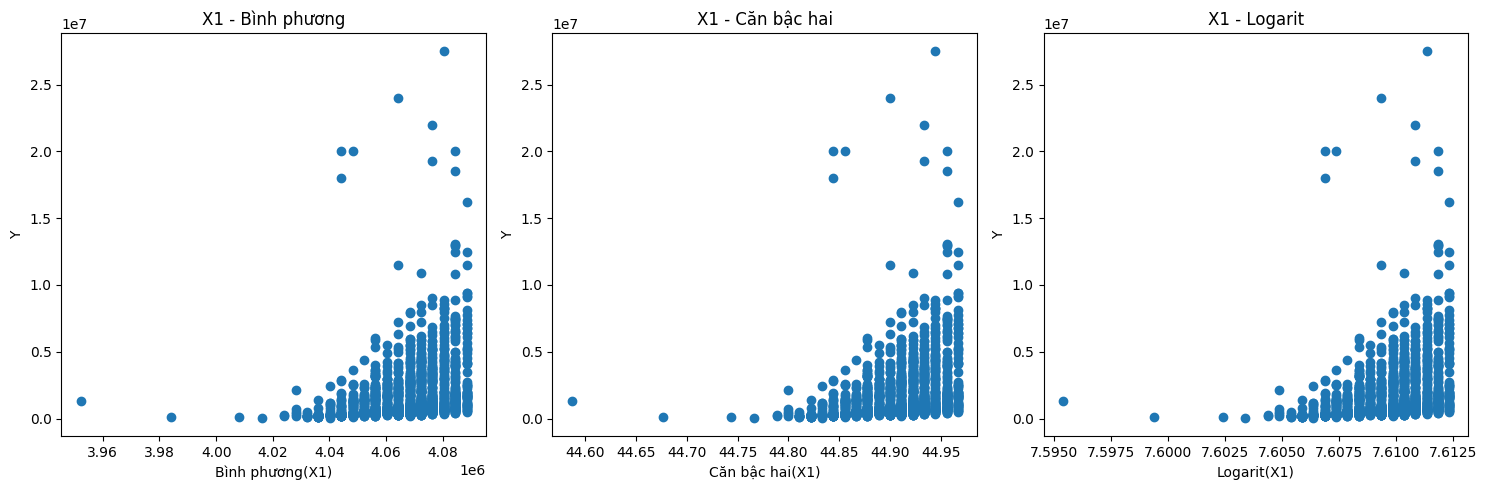

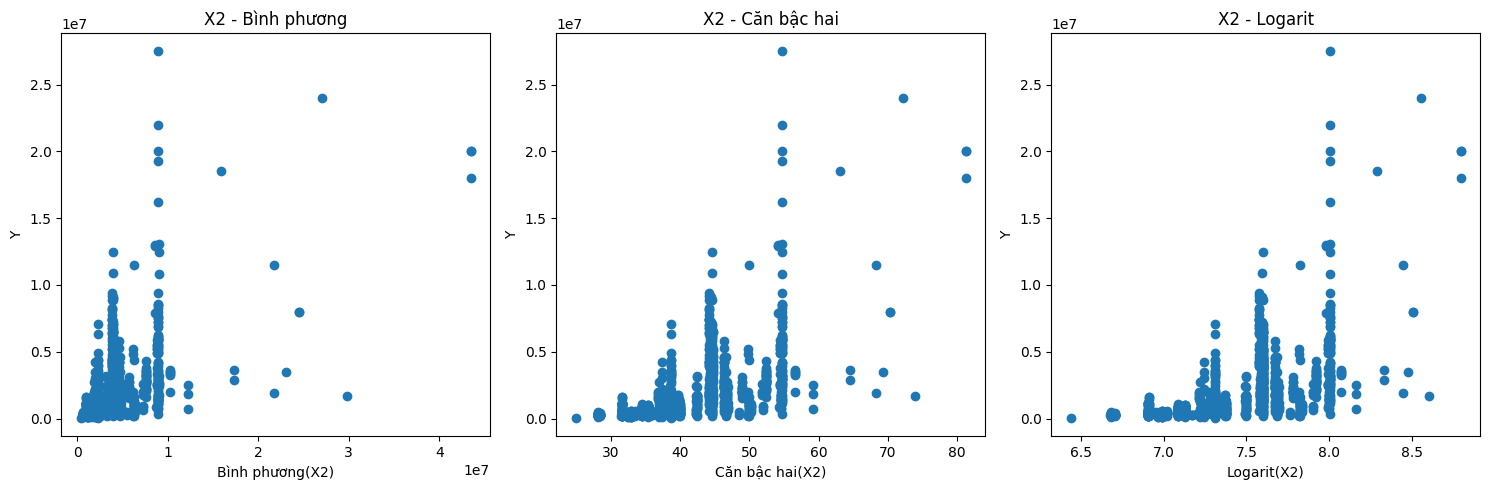

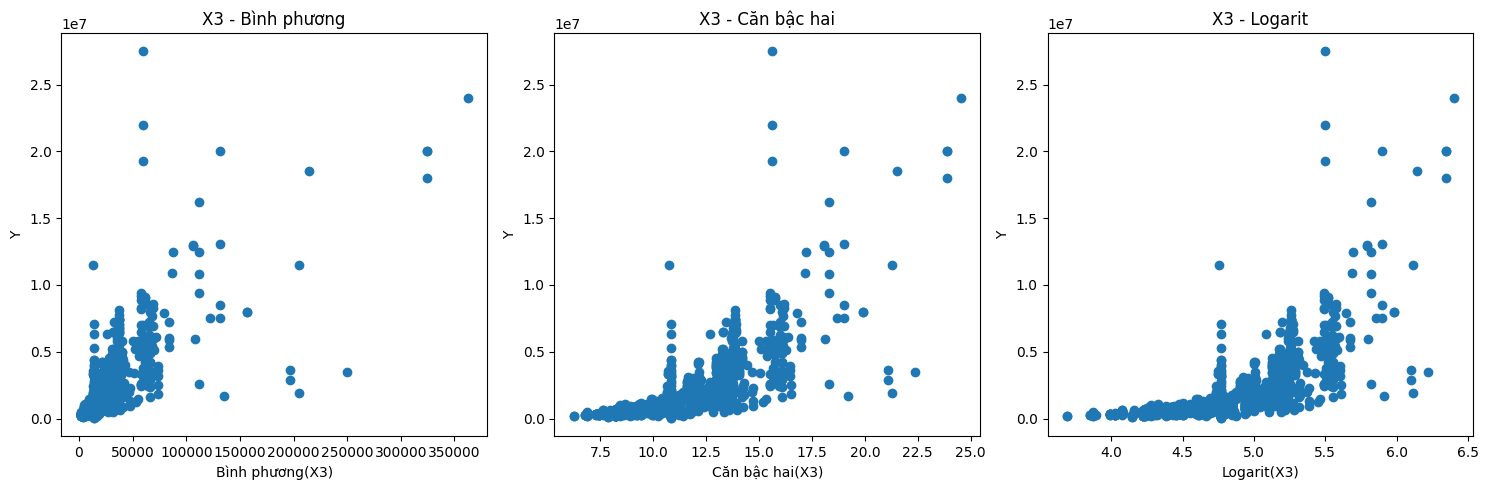

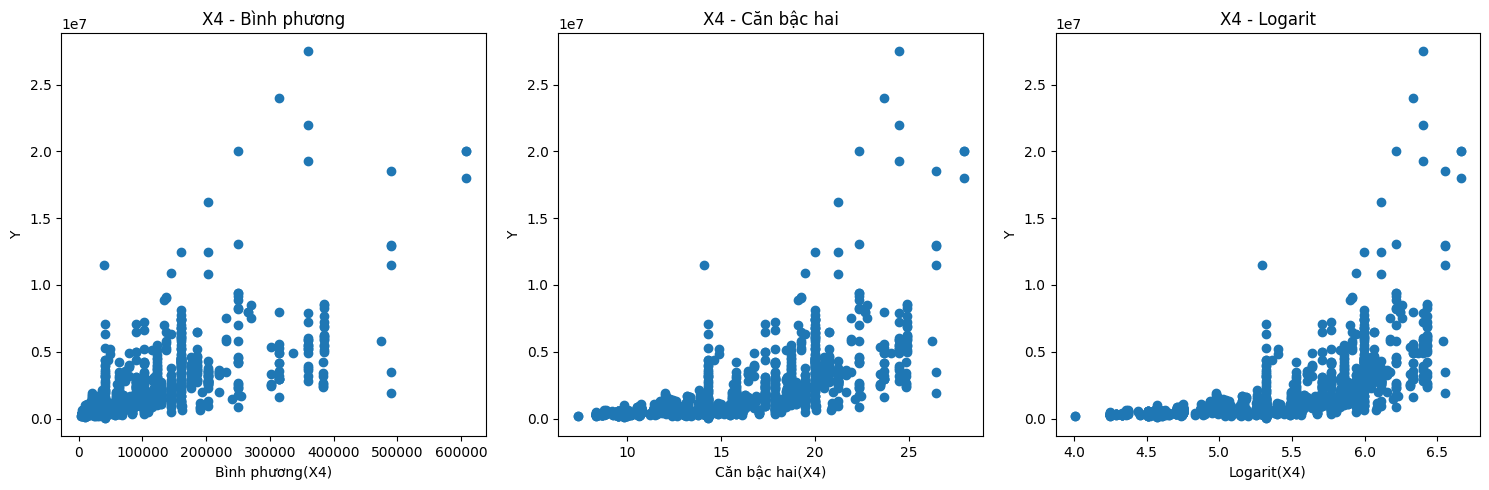

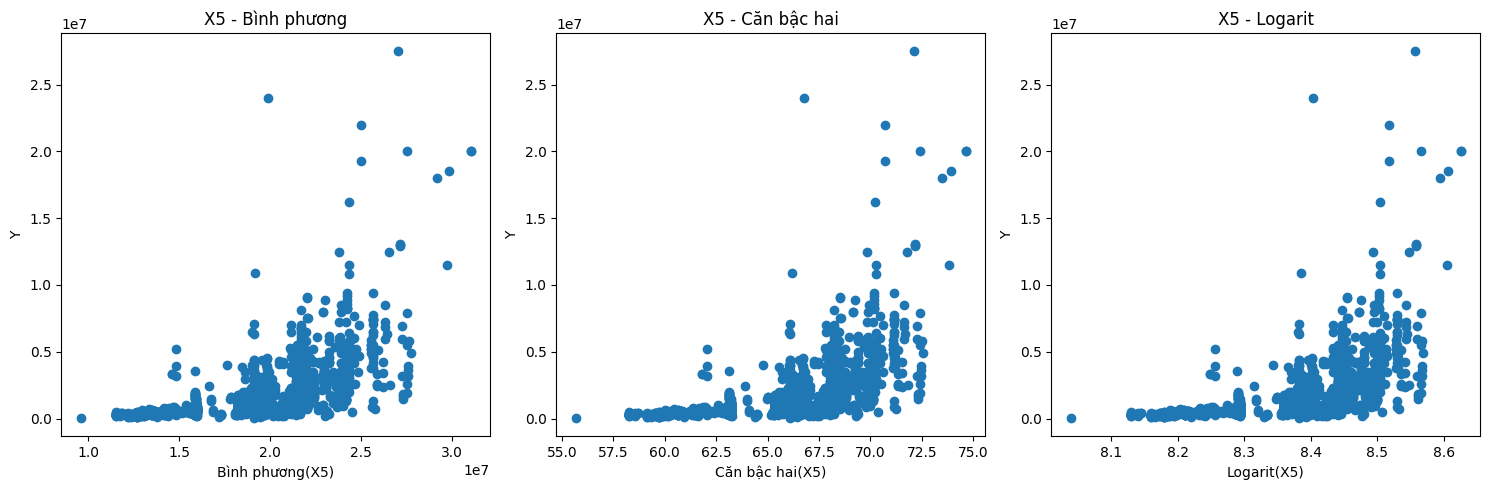

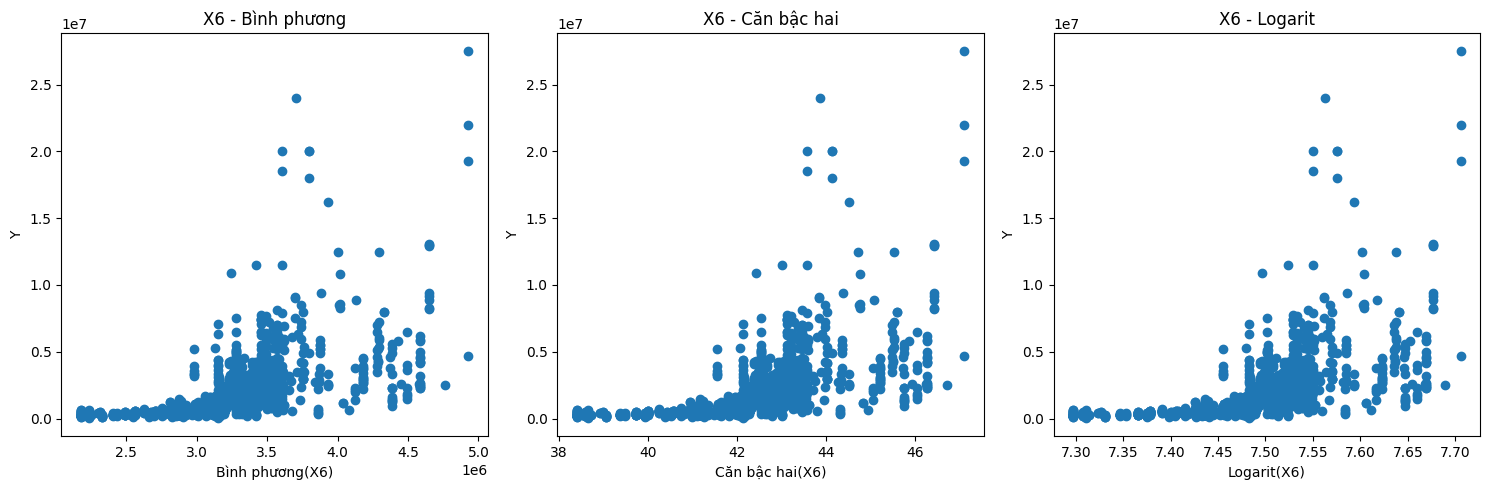

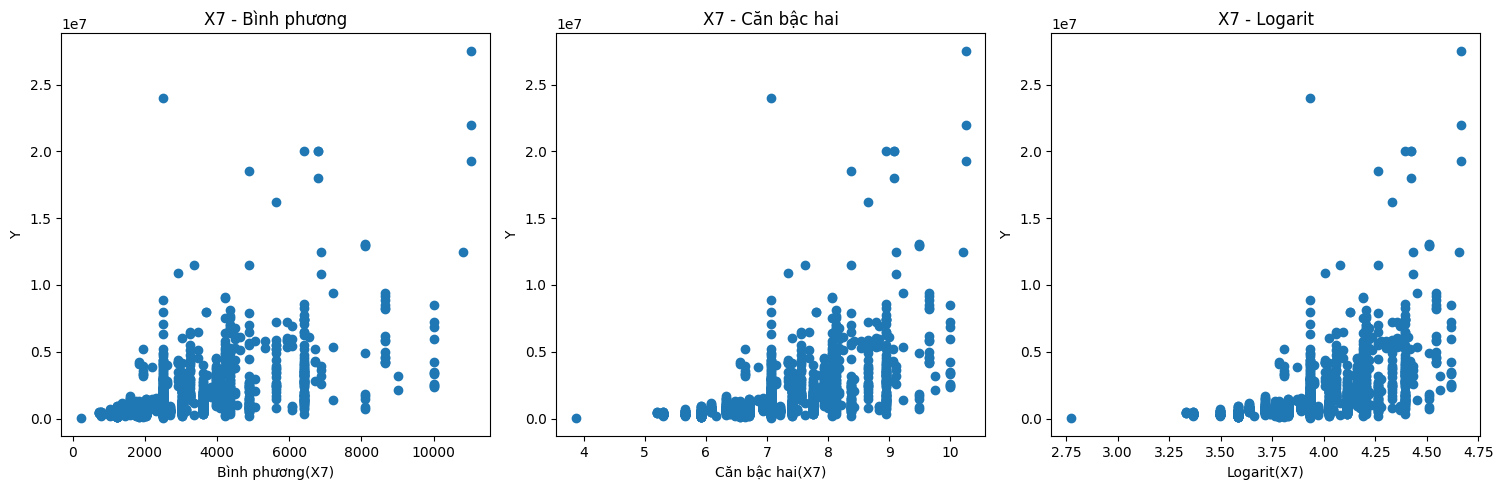

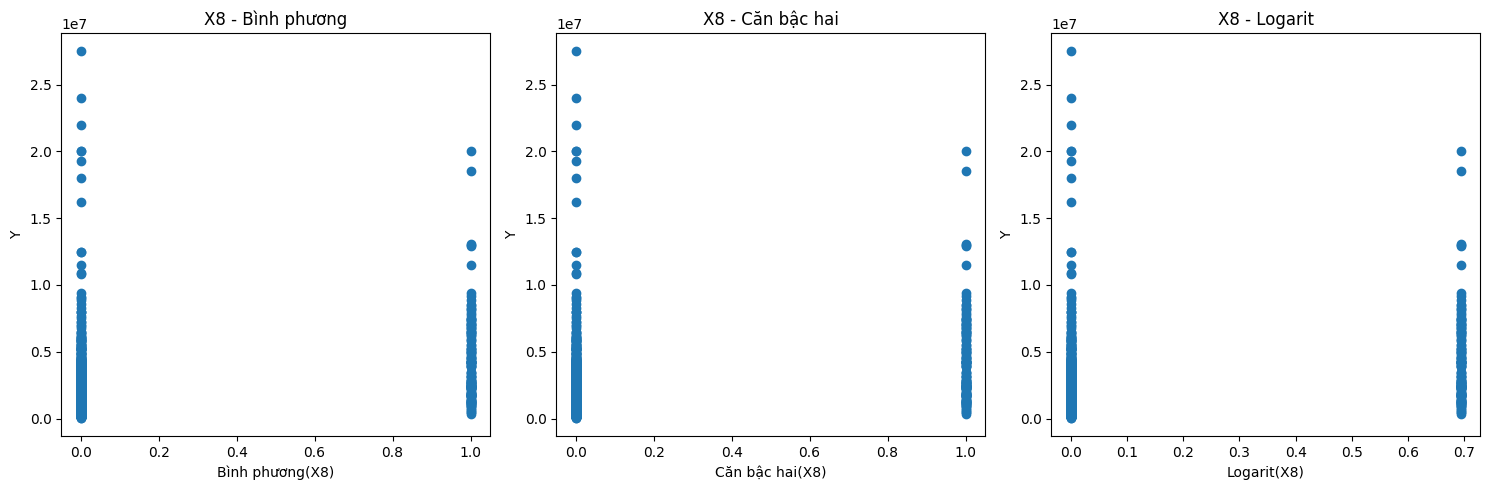

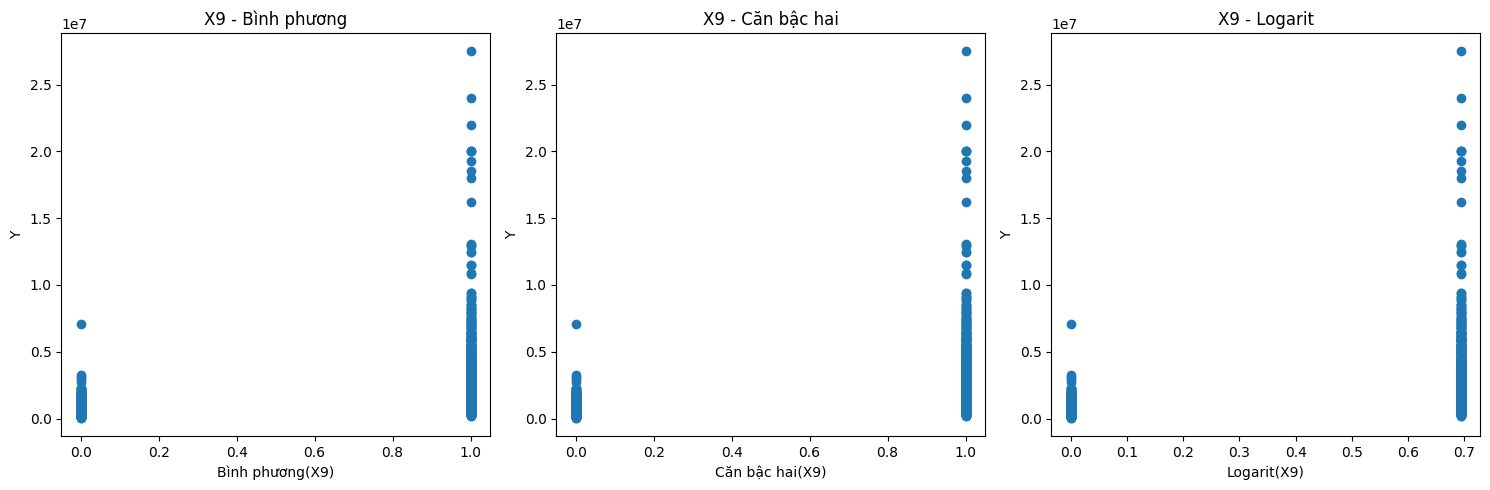

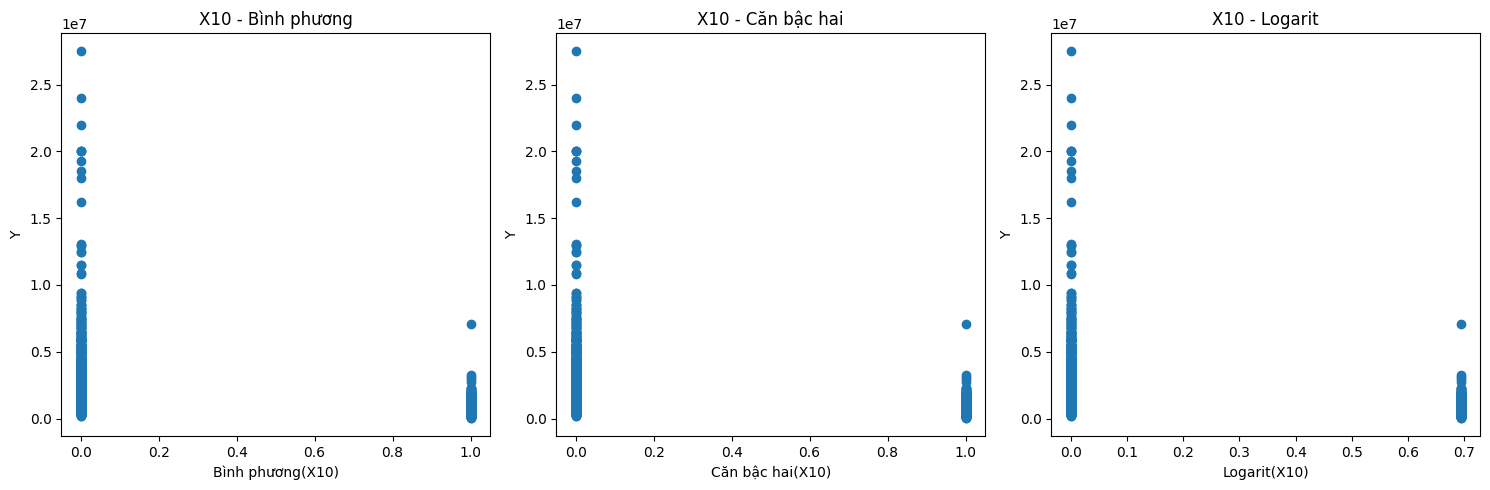

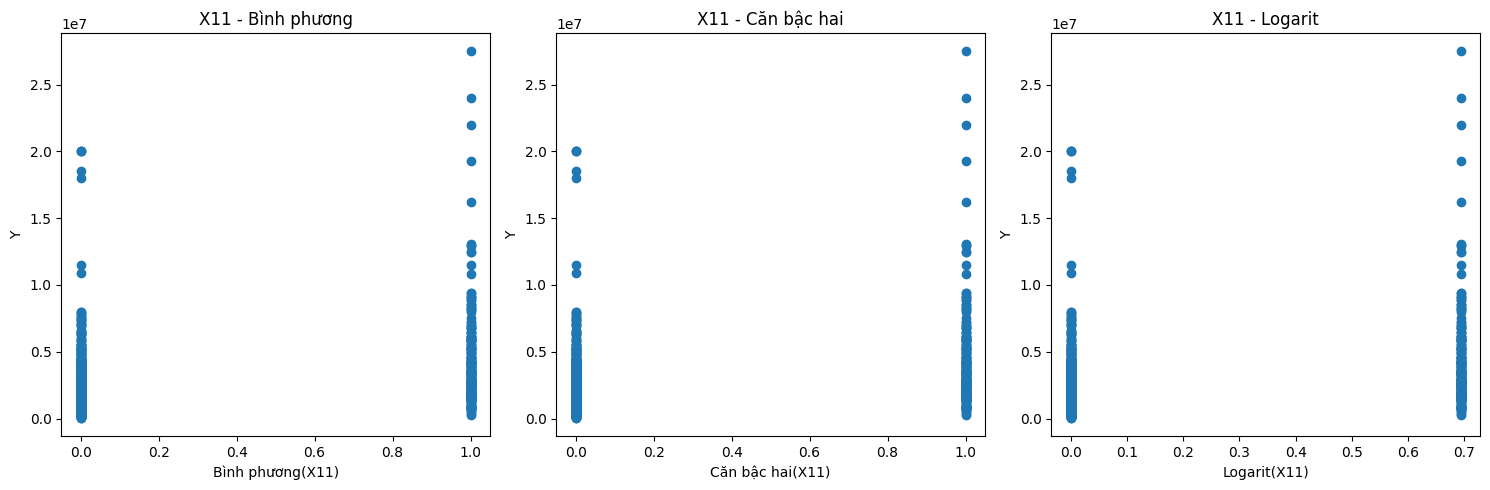

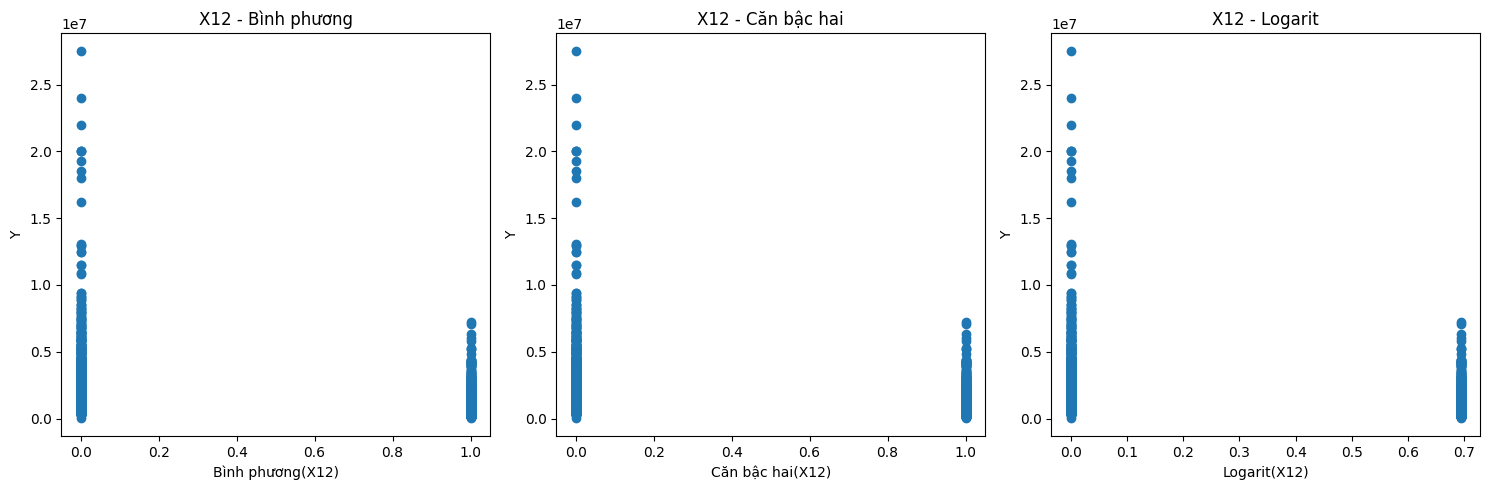

,Biến,Tuyến tính,Bình phương,Căn bậc hai,Logarit,Nghịch đảo,Bậc 3
0,X1,0.311086,0.311318,0.310969,0.310851,0.310615,0.311549
1,X2,0.622815,0.620004,0.604388,0.579107,0.518085,0.554634
2,X3,0.768741,0.758253,0.732600,0.681048,0.560156,0.659831
3,X4,0.678717,0.714324,0.640574,0.591501,0.477577,0.705942
4,X5,0.573735,0.593100,0.563720,0.553533,0.532758,0.611358
5,X6,0.576763,0.588466,0.569909,0.562439,0.545799,0.597349
6,X7,0.582416,0.598495,0.568670,0.551868,0.506448,0.600267
7,X8,0.343600,0.343600,0.343600,0.343600,0.343600,0.343600
8,X9,0.481164,0.481164,0.481164,0.481164,0.481164,0.481164
9,X10,0.481164,0.481164,0.481164,0.481164,0.481164,0.481164


In [155]:
analyze_variables(X, Y)

##Chuẩn hóa dữ liệu trước khi train

In [156]:
def compute_normalization_params(X):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0) + 1e-10
    return mean_X, std_X

## Các công thức được chọn dựa vào bảng tương quan giữa các biến và bảng tương quan các biến với các phép biến đổi

### **1. Công thức hồi quy 1**



$$
\hat{Y} = \theta_0 + \sum_{i=1}^{12} \theta_i X_i
$$

In [157]:
def create_features1(X):
    return np.column_stack([
        np.ones(X.shape[0]),
        X[:, 0],
        X[:, 1],
        X[:, 2] ,
        X[:, 3],
        X[:, 4] ,
        X[:, 5] ,
        X[:, 6] ,
        X[:, 7] ,
        X[:, 8] ,
        X[:, 9],
        X[:, 10],
        X[:, 11]
    ])

def preprocess_X_Y_1(X, Y, mean_X=None, std_X=None):
    if mean_X is None or std_X is None:
        mean_X, std_X = compute_normalization_params(X)

    X_normalized = (X - mean_X) / std_X

    Y = np.log(Y.flatten() + 1)

    X_transformed = create_features1(X_normalized)

    return X_transformed, Y, mean_X, std_X

def normal_equation(X, Y):
    lambda_reg = 0.1
    n_features = X.shape[1]
    reg_matrix = lambda_reg *  np.eye(n_features)
    reg_matrix[0, 0] = 0

    return np.linalg.pinv(X.T @ X + reg_matrix) @ X.T @ Y

def evaluate_model(folds):
    r2_scores, mse_scores, mae_scores = [], [], []
    r2_train_scores, mse_train_scores, mae_train_scores = [], [], []

    all_theta = []
    all_mean_X = []
    all_std_X = []
    mean_X_train, std_X_train = None, None

    for fold_idx, (X_train, Y_train, X_val, Y_val) in enumerate(folds):
        try:
            X_train_transformed, Y_train_transformed, mean_X, std_X = preprocess_X_Y_1(X_train, Y_train)
            X_val_transformed, Y_val_transformed, _, _ = preprocess_X_Y_1(X_val, Y_val, mean_X, std_X)

            if mean_X_train is None and std_X_train is None:
                mean_X_train, std_X_train = mean_X, std_X

            theta = normal_equation(X_train_transformed, Y_train_transformed.reshape(-1, 1))

            Y_pred_val = X_val_transformed @ theta
            mse_val = np.mean((np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())) ** 2)
            mae_val = np.mean(np.abs(np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())))
            r2_val = 1 - np.sum((Y_val_transformed - Y_pred_val.flatten()) ** 2) / np.sum((Y_val_transformed - np.mean(Y_val_transformed)) ** 2)

            Y_pred_train = X_train_transformed @ theta
            mse_train = np.mean((np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())) ** 2)
            mae_train = np.mean(np.abs(np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())))
            r2_train = 1 - np.sum((Y_train_transformed - Y_pred_train.flatten()) ** 2) / np.sum((Y_train_transformed - np.mean(Y_train_transformed)) ** 2)

            r2_scores.append(r2_val)
            mse_scores.append(mse_val)
            mae_scores.append(mae_val)

            r2_train_scores.append(r2_train)
            mse_train_scores.append(mse_train)
            mae_train_scores.append(mae_train)

            all_theta.append(theta)
            all_mean_X.append(mean_X)
            all_std_X.append(std_X)

            print(f"Fold {fold_idx + 1}:")
            print(f"  Train     -> R^2 = {r2_train:.4f}, MSE = {mse_train:.4f}, MAE = {mae_train:.4f}")
            print(f"  Validation-> R^2 = {r2_val:.4f}, MSE = {mse_val:.4f}, MAE = {mae_val:.4f}")

        except Exception as e:
            print(f"Error in fold {fold_idx + 1}: {e}")

    print("\nAverage Metrics on Training Set:")
    print(f"  R^2: {np.mean(r2_train_scores):.4f}")
    print(f"  MAE: {np.mean(mae_train_scores):.4f}")

    print("\nAverage Metrics on Validation Set:")
    print(f"  R^2: {np.mean(r2_scores):.4f}")
    print(f"  MAE: {np.mean(mae_scores):.4f}")

    theta_final = np.mean(all_theta, axis=0)
    mean_X_final = np.mean(all_mean_X, axis=0)
    std_X_final = np.mean(all_std_X, axis=0)

    return theta_final, mean_X_final, std_X_final
theta1, mean_X1, std_X1 = evaluate_model(folds)

Fold 1:
  Train     -> R^2 = 0.8962, MSE = 1278038915675.8652, MAE = 424019.2242
  Validation-> R^2 = 0.9114, MSE = 686224193876.8746, MAE = 383459.3262
Fold 2:
  Train     -> R^2 = 0.8978, MSE = 1186722836257.3706, MAE = 418093.2517
  Validation-> R^2 = 0.8978, MSE = 1855064797438.2131, MAE = 436380.2532
Fold 3:
  Train     -> R^2 = 0.8996, MSE = 1099321544042.7302, MAE = 405194.1028
  Validation-> R^2 = 0.8811, MSE = 3055540673133.8652, MAE = 602465.9865
Fold 4:
  Train     -> R^2 = 0.8962, MSE = 1259105151908.5876, MAE = 416990.1621
  Validation-> R^2 = 0.9113, MSE = 1243395750215.7019, MAE = 467330.2005
Fold 5:
  Train     -> R^2 = 0.8990, MSE = 1317549506025.9370, MAE = 427394.9202
  Validation-> R^2 = 0.8862, MSE = 496704307534.3439, MAE = 374444.2306
Fold 6:
  Train     -> R^2 = 0.9003, MSE = 1248519211892.0396, MAE = 416776.9298
  Validation-> R^2 = 0.8737, MSE = 1210167901468.4973, MAE = 446378.0098
Fold 7:
  Train     -> R^2 = 0.8976, MSE = 1133901205241.8884, MAE = 408646.36

### **2. Công thức hồi quy 2**


$$
\hat{Y} = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \theta_3 X_3 + \theta_4 X_4^2 + \theta_0 + \theta_5 X_5^3 + \theta_6 X_6 + \theta_7 \log(X_7) + \theta_8 \log(X_8) + \theta_9 X_9 + \theta_{10} X_{10} + \theta_{11} X_{11} + \theta_{12} X_{12}
$$



In [158]:
def create_features2(X):
    return np.column_stack([
        np.ones(X.shape[0]),
        X[:, 0],
        X[:, 1],
        X[:, 2] ,
        X[:, 3] ** 2,
        X[:, 4] ** 3,
        X[:, 5] ,
        X[:, 6] ,
        np.log(np.maximum(X[:, 7], 1e-10)),
        np.log(np.maximum(X[:, 8], 1e-10)),
        X[:, 9],
        X[:, 10],
        X[:, 11]
    ])

def preprocess_X_Y_2(X, Y, mean_X=None, std_X=None):
    if mean_X is None or std_X is None:
        mean_X, std_X = compute_normalization_params(X)  # Tính nếu chưa có

    X_normalized = (X - mean_X) / std_X

    Y = np.log(Y.flatten() + 1)

    X_transformed = create_features2(X_normalized)

    return X_transformed, Y, mean_X, std_X

def normal_equation(X, Y):
    lambda_reg = 0.1
    n_features = X.shape[1]
    reg_matrix = lambda_reg * np.eye(n_features)
    reg_matrix[0, 0] = 0

    return np.linalg.pinv(X.T @ X + reg_matrix) @ X.T @ Y

def evaluate_model(folds):
    r2_scores, mse_scores, mae_scores = [], [], []
    r2_train_scores, mse_train_scores, mae_train_scores = [], [], []

    all_theta = []
    all_mean_X = []
    all_std_X = []
    mean_X_train, std_X_train = None, None

    for fold_idx, (X_train, Y_train, X_val, Y_val) in enumerate(folds):
        try:
            X_train_transformed, Y_train_transformed, mean_X, std_X = preprocess_X_Y_2(X_train, Y_train)
            X_val_transformed, Y_val_transformed, _, _ = preprocess_X_Y_2(X_val, Y_val, mean_X, std_X)

            if mean_X_train is None and std_X_train is None:
                mean_X_train, std_X_train = mean_X, std_X

            theta = normal_equation(X_train_transformed, Y_train_transformed.reshape(-1, 1))

            Y_pred_val = X_val_transformed @ theta
            mse_val = np.mean((np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())) ** 2)
            mae_val = np.mean(np.abs(np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())))
            r2_val = 1 - np.sum((Y_val_transformed - Y_pred_val.flatten()) ** 2) / np.sum((Y_val_transformed - np.mean(Y_val_transformed)) ** 2)

            Y_pred_train = X_train_transformed @ theta
            mse_train = np.mean((np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())) ** 2)
            mae_train = np.mean(np.abs(np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())))
            r2_train = 1 - np.sum((Y_train_transformed - Y_pred_train.flatten()) ** 2) / np.sum((Y_train_transformed - np.mean(Y_train_transformed)) ** 2)

            r2_scores.append(r2_val)
            mse_scores.append(mse_val)
            mae_scores.append(mae_val)

            r2_train_scores.append(r2_train)
            mse_train_scores.append(mse_train)
            mae_train_scores.append(mae_train)

            all_theta.append(theta)
            all_mean_X.append(mean_X)
            all_std_X.append(std_X)

            print(f"Fold {fold_idx + 1}:")
            print(f"  Train     -> R^2 = {r2_train:.4f}, MSE = {mse_train:.4f}, MAE = {mae_train:.4f}")
            print(f"  Validation-> R^2 = {r2_val:.4f}, MSE = {mse_val:.4f}, MAE = {mae_val:.4f}")

        except Exception as e:
            print(f"Error in fold {fold_idx + 1}: {e}")

    print("\nAverage Metrics on Training Set:")
    print(f"  R^2: {np.mean(r2_train_scores):.4f}")
    print(f"  MAE: {np.mean(mae_train_scores):.4f}")

    print("\nAverage Metrics on Validation Set:")
    print(f"  R^2: {np.mean(r2_scores):.4f}")
    print(f"  MAE: {np.mean(mae_scores):.4f}")

    theta_final = np.mean(all_theta, axis=0)
    mean_X_final = np.mean(all_mean_X, axis=0)
    std_X_final = np.mean(all_std_X, axis=0)

    return theta_final, mean_X_final, std_X_final

theta2, mean_X2, std_X2 = evaluate_model(folds)

Fold 1:
  Train     -> R^2 = 0.8927, MSE = 1368887723600.6626, MAE = 438620.4525
  Validation-> R^2 = 0.8977, MSE = 949544506382.2999, MAE = 443958.7975
Fold 2:
  Train     -> R^2 = 0.8925, MSE = 1228326982747.0605, MAE = 440975.4202
  Validation-> R^2 = 0.9003, MSE = 1637963208196.8701, MAE = 416601.9438
Fold 3:
  Train     -> R^2 = 0.8938, MSE = 1140669416786.6389, MAE = 424673.4531
  Validation-> R^2 = 0.8861, MSE = 2998681275697.2925, MAE = 612872.8531
Fold 4:
  Train     -> R^2 = 0.8912, MSE = 1337926182659.0171, MAE = 443499.6682
  Validation-> R^2 = 0.9116, MSE = 702192178291.4027, MAE = 414176.5910
Fold 5:
  Train     -> R^2 = 0.8940, MSE = 1370518453690.5239, MAE = 443473.6358
  Validation-> R^2 = 0.8872, MSE = 752451943593.7969, MAE = 411065.8692
Fold 6:
  Train     -> R^2 = 0.8959, MSE = 1311820777191.1399, MAE = 438279.6138
  Validation-> R^2 = 0.8682, MSE = 805251579855.4138, MAE = 432899.3885
Fold 7:
  Train     -> R^2 = 0.8932, MSE = 1095737856673.9319, MAE = 423218.7162


###**3. Công thức hồi quy 3**

  
$$
\hat{Y} = \theta_0 + \sum_{i=1}^{12} \theta_i X_i + \sum_{i=1}^{12} \theta_{i} X_i^2 + \sum_{i=1}^{12} \sum_{j=i+1}^{12} \theta_{ij} (X_i X_j) + \sum_{i=1}^{12} \theta_{i} \sqrt{|X_i|}
$$


In [159]:
def create_features3(X):
    n_samples = X.shape[0]
    features = [np.ones(n_samples)]

    for i in range(X.shape[1]):
        features.append(X[:, i])

    for i in range(X.shape[1]):
        features.append(X[:, i]**2)

    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            features.append(X[:, i] * X[:, j])

    for i in range(X.shape[1]):
        features.append(np.sqrt(np.abs(X[:, i]) + 1e-10))

    return np.column_stack(features)

def preprocess_X_Y_3(X, Y, mean_X=None, std_X=None):
    if mean_X is None or std_X is None:
        mean_X, std_X = compute_normalization_params(X)  # Tính nếu chưa có

    X_normalized = (X - mean_X) / std_X

    Y = np.log(Y.flatten() + 1)

    X_transformed = create_features3(X_normalized)

    return X_transformed, Y, mean_X, std_X

def normal_equation(X, Y):
    lambda_reg = 0.1
    n_features = X.shape[1]
    reg_matrix = lambda_reg * np.eye(n_features)
    reg_matrix[0, 0] = 0

    return np.linalg.pinv(X.T @ X + reg_matrix) @ X.T @ Y

def evaluate_model(folds):
    r2_scores, mse_scores, mae_scores = [], [], []
    r2_train_scores, mse_train_scores, mae_train_scores = [], [], []

    all_theta = []
    all_mean_X = []
    all_std_X = []
    mean_X_train, std_X_train = None, None

    for fold_idx, (X_train, Y_train, X_val, Y_val) in enumerate(folds):
        try:
            X_train_transformed, Y_train_transformed, mean_X, std_X = preprocess_X_Y_3(X_train, Y_train)
            X_val_transformed, Y_val_transformed, _, _ = preprocess_X_Y_3(X_val, Y_val, mean_X, std_X)

            if mean_X_train is None and std_X_train is None:
                mean_X_train, std_X_train = mean_X, std_X

            theta = normal_equation(X_train_transformed, Y_train_transformed.reshape(-1, 1))

            Y_pred_val = X_val_transformed @ theta
            mse_val = np.mean((np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())) ** 2)
            mae_val = np.mean(np.abs(np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())))
            r2_val = 1 - np.sum((Y_val_transformed - Y_pred_val.flatten()) ** 2) / np.sum((Y_val_transformed - np.mean(Y_val_transformed)) ** 2)

            Y_pred_train = X_train_transformed @ theta
            mse_train = np.mean((np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())) ** 2)
            mae_train = np.mean(np.abs(np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())))
            r2_train = 1 - np.sum((Y_train_transformed - Y_pred_train.flatten()) ** 2) / np.sum((Y_train_transformed - np.mean(Y_train_transformed)) ** 2)

            r2_scores.append(r2_val)
            mse_scores.append(mse_val)
            mae_scores.append(mae_val)

            r2_train_scores.append(r2_train)
            mse_train_scores.append(mse_train)
            mae_train_scores.append(mae_train)

            all_theta.append(theta)
            all_mean_X.append(mean_X)
            all_std_X.append(std_X)

            print(f"Fold {fold_idx + 1}:")
            print(f"  Train     -> R^2 = {r2_train:.4f}, MSE = {mse_train:.4f}, MAE = {mae_train:.4f}")
            print(f"  Validation-> R^2 = {r2_val:.4f}, MSE = {mse_val:.4f}, MAE = {mae_val:.4f}")

        except Exception as e:
            print(f"Error in fold {fold_idx + 1}: {e}")

    print("\nAverage Metrics on Training Set:")
    print(f"  R^2: {np.mean(r2_train_scores):.4f}")
    print(f"  MAE: {np.mean(mae_train_scores):.4f}")

    print("\nAverage Metrics on Validation Set:")
    print(f"  R^2: {np.mean(r2_scores):.4f}")
    print(f"  MAE: {np.mean(mae_scores):.4f}")

    theta_final = np.mean(all_theta, axis=0)
    mean_X_final = np.mean(all_mean_X, axis=0)
    std_X_final = np.mean(all_std_X, axis=0)

    return theta_final, mean_X_final, std_X_final

theta3, mean_X3, std_X3 = evaluate_model(folds)

Fold 1:
  Train     -> R^2 = 0.9303, MSE = 560920569731.5508, MAE = 312485.1653
  Validation-> R^2 = 0.9131, MSE = 1141233399657.3472, MAE = 373330.6033
Fold 2:
  Train     -> R^2 = 0.9298, MSE = 553573004022.5808, MAE = 314967.8883
  Validation-> R^2 = 0.9228, MSE = 540926127180.1734, MAE = 291672.8742
Fold 3:
  Train     -> R^2 = 0.9331, MSE = 569768391708.0714, MAE = 309276.3551
  Validation-> R^2 = 0.8991, MSE = 1882542641258.6868, MAE = 502751.9920
Fold 4:
  Train     -> R^2 = 0.9295, MSE = 531953726818.5118, MAE = 314569.8996
  Validation-> R^2 = 0.9332, MSE = 1084022047747.1307, MAE = 387622.9847
Fold 5:
  Train     -> R^2 = 0.9325, MSE = 591776694417.3173, MAE = 317861.9639
  Validation-> R^2 = 0.9027, MSE = 307201321562.0754, MAE = 309638.5963
Fold 6:
  Train     -> R^2 = 0.9322, MSE = 597244082492.8130, MAE = 320457.7316
  Validation-> R^2 = 0.9037, MSE = 1097891153928.0682, MAE = 420994.5403
Fold 7:
  Train     -> R^2 = 0.9304, MSE = 513185718308.7964, MAE = 308268.9313
  Va

### **4. Công thức hồi quy 4**


$$
\hat{Y} = \theta_0 + \sum_{i=1}^{12} \theta_i X_i + \sum_{i=1}^{12} \theta_{i} X_i^2 + \sum_{i=1}^{12} \sum_{j=i+1}^{12} \theta_{ij} (X_i X_j) + \sum_{i=1}^{12} \theta_{i} \sqrt{|X_i|} + \sum_{i=1}^{12} \theta_{i} \log(|X_i| + 1e-10) + \sum_{i=1}^{12} \theta_{i} e^{X_i} + \sum_{i=1}^{12} \theta_{i} \frac{1}{X_i + 1e-10}
$$

In [160]:
def create_features4(X):
    n_samples = X.shape[0]
    features = [np.ones(n_samples)]  # Hệ số chặn (bias)

    for i in range(X.shape[1]):
        features.append(X[:, i])

    for i in range(X.shape[1]):
        features.append(X[:, i]**2)

    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            features.append(X[:, i] * X[:, j])

    for i in range(X.shape[1]):
        features.append(np.sqrt(np.abs(X[:, i]) + 1e-10))

    for i in range(X.shape[1]):
        features.append(np.log(np.abs(X[:, i]) + 1e-10))

    for i in range(X.shape[1]):
        features.append(np.exp(X[:, i]))

    for i in range(X.shape[1]):
        features.append(1 / (X[:, i] + 1e-10))

    return np.column_stack(features)

def preprocess_X_Y_4(X, Y, mean_X=None, std_X=None):
    if mean_X is None or std_X is None:
        mean_X, std_X = compute_normalization_params(X)

    X_normalized = (X - mean_X) / std_X
    Y = np.log(Y.flatten() + 1)
    X_transformed = create_features4(X_normalized)

    return X_transformed, Y, mean_X, std_X

def normal_equation(X, Y):
    lambda_reg = 0.1
    n_features = X.shape[1]
    reg_matrix = lambda_reg * np.eye(n_features)
    reg_matrix[0, 0] = 0

    return np.linalg.pinv(X.T @ X + reg_matrix) @ X.T @ Y

def evaluate_model(folds):
    r2_scores, mse_scores, mae_scores = [], [], []
    r2_train_scores, mse_train_scores, mae_train_scores = [], [], []

    all_theta = []
    all_mean_X = []
    all_std_X = []
    mean_X_train, std_X_train = None, None

    for fold_idx, (X_train, Y_train, X_val, Y_val) in enumerate(folds):
        try:
            X_train_transformed, Y_train_transformed, mean_X, std_X = preprocess_X_Y_4(X_train, Y_train)
            X_val_transformed, Y_val_transformed, _, _ = preprocess_X_Y_4(X_val, Y_val, mean_X, std_X)

            if mean_X_train is None and std_X_train is None:
                mean_X_train, std_X_train = mean_X, std_X

            theta = normal_equation(X_train_transformed, Y_train_transformed.reshape(-1, 1))

            Y_pred_val = X_val_transformed @ theta
            mse_val = np.mean((np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())) ** 2)
            mae_val = np.mean(np.abs(np.expm1(Y_val_transformed) - np.expm1(Y_pred_val.flatten())))
            r2_val = 1 - np.sum((Y_val_transformed - Y_pred_val.flatten()) ** 2) / np.sum((Y_val_transformed - np.mean(Y_val_transformed)) ** 2)

            Y_pred_train = X_train_transformed @ theta
            mse_train = np.mean((np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())) ** 2)
            mae_train = np.mean(np.abs(np.expm1(Y_train_transformed) - np.expm1(Y_pred_train.flatten())))
            r2_train = 1 - np.sum((Y_train_transformed - Y_pred_train.flatten()) ** 2) / np.sum((Y_train_transformed - np.mean(Y_train_transformed)) ** 2)

            r2_scores.append(r2_val)
            mse_scores.append(mse_val)
            mae_scores.append(mae_val)

            r2_train_scores.append(r2_train)
            mse_train_scores.append(mse_train)
            mae_train_scores.append(mae_train)

            all_theta.append(theta)
            all_mean_X.append(mean_X)
            all_std_X.append(std_X)

            print(f"Fold {fold_idx + 1}:")
            print(f"  Train     -> R^2 = {r2_train:.4f}, MSE = {mse_train:.4f}, MAE = {mae_train:.4f}")
            print(f"  Validation-> R^2 = {r2_val:.4f}, MSE = {mse_val:.4f}, MAE = {mae_val:.4f}")

        except Exception as e:
            print(f"Error in fold {fold_idx + 1}: {e}")

    print("\nAverage Metrics on Training Set:")
    print(f"  R^2: {np.mean(r2_train_scores):.4f}")
    print(f"  MAE: {np.mean(mae_train_scores):.4f}")

    print("\nAverage Metrics on Validation Set:")
    print(f"  R^2: {np.mean(r2_scores):.4f}")
    print(f"  MAE: {np.mean(mae_scores):.4f}")

    theta_final = np.mean(all_theta, axis=0)
    mean_X_final = np.mean(all_mean_X, axis=0)
    std_X_final = np.mean(all_std_X, axis=0)

    return theta_final, mean_X_final, std_X_final

theta4, mean_X4, std_X4 = evaluate_model(folds)

Fold 1:
  Train     -> R^2 = 0.9367, MSE = 508895925863.8686, MAE = 299079.0633
  Validation-> R^2 = 0.9255, MSE = 357254713020.2152, MAE = 307689.9396
Fold 2:
  Train     -> R^2 = 0.9360, MSE = 472337919834.4456, MAE = 296913.4283
  Validation-> R^2 = 0.9308, MSE = 1342773466602.0330, MAE = 361080.2971
Fold 3:
  Train     -> R^2 = 0.9389, MSE = 454704259638.7807, MAE = 286803.4689
  Validation-> R^2 = 0.9085, MSE = 1460153204017.5337, MAE = 470433.0334
Fold 4:
  Train     -> R^2 = 0.9368, MSE = 389300708086.1436, MAE = 285659.1212
  Validation-> R^2 = 0.9292, MSE = 1553065694121.9482, MAE = 453255.4530
Fold 5:
  Train     -> R^2 = 0.9383, MSE = 425136544025.3368, MAE = 291302.7551
  Validation-> R^2 = 0.9086, MSE = 415355487300.0133, MAE = 327765.3131
Fold 6:
  Train     -> R^2 = 0.9382, MSE = 494327999344.7121, MAE = 299575.0257
  Validation-> R^2 = 0.9135, MSE = 568270203496.7173, MAE = 356508.2934
Fold 7:
  Train     -> R^2 = 0.9359, MSE = 477771385365.6146, MAE = 294737.7756
  Val

# *Kiểm lại mô hình*

### Đọc tập test từ link

In [161]:
def download_google_sheets_test(sheet_url, file_path):
    try:
        sheet_id = sheet_url.split("/d/")[1].split("/")[0]
        gid = sheet_url.split("gid=")[1] if "gid=" in sheet_url else "0"
        csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&id={sheet_id}&gid={gid}"

        df = pd.read_csv(csv_url)
        df.to_csv(file_path, index=False)
        print(f"File đã tải xuống và lưu tại: {file_path}")
        return df
    except Exception as e:
        print(f"Lỗi khi tải file: {e}")
        return None

In [162]:
#Hãy truyền link vào csv_url
csv_url = "https://docs.google.com/spreadsheets/d/1_R3YQJf18f4ZyWZfVaTiRYWN4jiwlPsucdnc-NMKEUU/edit?gid=1072197058#gid=1072197058"
df_test = download_google_sheets_test(csv_url, "test.csv")

File đã tải xuống và lưu tại: test.csv


In [163]:
df_test

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,Mahindra,XUV500 W8 [2015-2017],850000,2016,90300,Diesel,Manual,Surat,White,First,Individual,2179 cc,138 bhp @ 3750 rpm,330 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
2055,Hyundai,Eon D-Lite +,275000,2014,83000,Petrol,Manual,Ahmedabad,White,Second,Individual,814 cc,55 bhp @ 5500 rpm,75 Nm @ 4000 rpm,FWD,3495.0,1550.0,1500.0,5.0,32.0
2056,Ford,Figo Duratec Petrol ZXI 1.2,240000,2013,73000,Petrol,Manual,Thane,Silver,First,Individual,1196 cc,70 bhp @ 6250 rpm,102 Nm @ 4000 rpm,FWD,3795.0,1680.0,1427.0,5.0,45.0
2057,BMW,5-Series 520d Luxury Line [2017-2019],4290000,2018,60474,Diesel,Automatic,Coimbatore,White,First,Individual,1995 cc,188 bhp @ 4000 rpm,400 Nm @ 1750 rpm,RWD,4936.0,1868.0,1479.0,5.0,65.0


### Xử lý tập test như tập train

In [164]:
def process_test_data(df_test, selected_columns, numerical_cols):

    # Tiền xử lý dữ liệu (chuyển đổi đơn vị, xử lý giá trị thiếu, xử lý các đặc trưng liên quan đến giá...)
    df_test = process_units(df_test)
    df_test = handle_missing_values(df_test)

    df_test = process_price_related_features(df_test)

    # Mã hóa các đặc trưng dạng categorical
    df_test = encode_categorical(df_test)

    X_scaled = df_test[numerical_cols].values

    return X_scaled


In [165]:
X_test = process_test_data(df_test, selected_columns, numerical_cols)

<ipython-input-137-e86bc27d251b>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-137-e86bc27d251b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

###Dự đoán giá

In [166]:
def predict_on_test(X_test, theta, mean_X, std_X, preprocess_func):
    """Dự đoán trên tập test, chuẩn hóa bằng mean_X và std_X từ tập huấn luyện."""

    X_test_transformed, _, _, _ = preprocess_func(X_test, np.zeros(X_test.shape[0]), mean_X, std_X)

    if X_test_transformed.shape[1] != theta.shape[0]:
        raise ValueError(f"Sai kích thước: X_test_transformed.shape = {X_test_transformed.shape}, theta.shape = {theta.shape}")

    Y_pred_log = X_test_transformed @ theta
    Y_pred = np.expm1(Y_pred_log)

    return Y_pred, Y_pred_log

###Dự đoán trên mô hình 4 : mô hình được huấn luyện tốt nhất

In [ ]:
Y_pred4, Y_pred_log4 = predict_on_test(X_test, theta4, mean_X4, std_X4, preprocess_X_Y_4)

In [168]:
def compute_metrics(Y_true, Y_pred, Y_pred_log):
    """ Tính R^2, MSE, MAE """
    Y_true_log = np.log(Y_true + 1)
    Y_pred = Y_pred.flatten()
    Y_pred_log = Y_pred_log.flatten()

    mse = np.mean(np.expm1(Y_true_log - Y_pred_log) ** 2)
    mae = np.mean(np.abs(Y_true - Y_pred))

    ss_res = np.sum((Y_true_log - Y_pred_log) ** 2)
    ss_tot = np.sum((Y_true_log - np.mean(Y_true_log)) ** 2)

    if ss_tot == 0:  # Tránh chia cho 0
        r2 = 0
    else:
        r2 = 1 - (ss_res / ss_tot)

    return r2, mse, mae

In [172]:
R2_4, MSE_4, MAE_4 = compute_metrics(df_test['Price'], Y_pred4, Y_pred_log4)
print("Độ chính xác của mô hình 4: ")
print(f"R^2: {R2_4:.4f}")
print(f"MSE: {MSE_4:.4f}")
print(f"MAE: {MAE_4:.4f}")

Độ chính xác của mô hình 4: 
R^2: 0.9316
MSE: 0.1080
MAE: 322251.2106
